### Library install :
- Python : `3.6`
- `conda install numpy`
- `conda install matplotlib`
- `conda install pandas`
- `conda instal scikit-learn`
- Opsi Tensorflow (**pilih salah satu**) :
    - `pip install tensorflow-gpu==1.12 --user` --> TF GPU | CUDA 9.0 | CuDNN 7.0 | GPU Driver Ver >= 385.xx
    - `pip install tensorflow-gpu==2.1 --user` --> TF GPU | CUDA 10.0 | CuDNN 7.6 | GPU Driver Ver >= 411.xx
    - `pip install tensorflow==2.1 --user` --> TF CPU
- `conda install keras`
- `conda install -c conda-forge ipykernel`

In [1]:
import os
# if GPU is not available, just disable GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_all.csv") > -1:
        filenames.append(filename)

In [2]:
filenames

['test_all.csv', 'train_all.csv']

In [3]:
# check available GPU
import tensorflow as tf

# tensorflow  2.x 
#tf.config.list_physical_devices('GPU') 

# tensorflow 1.x
with tf.Session() as sess:
    print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 6295680474123147857), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1502406247, 3336820631484996762)]


In [4]:
tf.__version__

'1.12.0'

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [6]:
train_df = pd.read_csv(dataset_folder + "train_all.csv", header=None)
test_df = pd.read_csv(dataset_folder + "test_all.csv" , header=None)

## Dataset AFDB
Dataset AFDB terdiri dari 601 kolom, dimana kolom ke 601 merupakan katerori/class.

In [7]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
0,0.393985,0.555521,0.721069,0.818955,0.868105,0.773658,0.434426,0.018929,-0.251642,-0.328875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.983883,0.984696,0.652842,0.139353,-0.198687,-0.322438,-0.321251,-0.275291,-0.214320,-0.152051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.798048,0.722501,0.440620,0.036416,-0.244279,-0.338472,-0.305032,-0.005253,0.111170,0.185074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.732998,0.557297,0.181725,-0.071875,-0.197233,-0.230429,-0.205410,-0.194221,-0.177818,-0.156198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.780055,0.582023,0.191672,-0.167712,-0.321306,-0.321839,-0.245187,-0.146123,-0.003543,0.132029,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


___
## Add Noise

- pada bagian ini kita tambahkan gaussian noise pada signal ECG 
- Noise yang akan ditambahkan adalah **Additive White Gaussian Noise (AWGN)**.
- Pada AWGN nilai rata-rata $\mu$ = 0, sehingga untuk tiap Gaussian random variable $X$, non-central second [moment](https://en.wikipedia.org/wiki/Normal_distribution#Moments) *E*[$X^{2}$] adalah: <br><br>
*E*[$X^{2}$] = $\mu^{2}$ + $\sigma^{2}$ <br><br>
sehingga, <br>
*E*[$X^{2}$] = $\sigma^{2}$ <br><br>
untuk, <br>
*E*[$X^{2}$] dalam konteks ini merupakan rata-rata noise, <br><br>
$NoiseAvg$ = $10^{NoiseAvg[db]/10}$ <br><br>
konversi baliknya ke-db, <br>
$NoiseAvg[db] = 10\times log(NoiseAvg)$ <br><br>
NoiseAvg bisa didapatkan dari formula $SNR$, <br>
$SNR[db]= Signal[db] - NoiseAvg[db]$ 
<br><br>
sehingga jika $SNR$ diset pada nilai tertentu, bisa didapatkan variance $\sigma^{2}$ yang nantinya dapat digunakan untuk menghasilkan white noise. 
- untuk menghasilkan white noise bisa digunakan library `numpy.random.normal()` dengan parameter `step` = $\sigma$ (std deviation)

In [8]:
fs = 250 #Hz

In [9]:
def add_AWGN_noise(signal, target_noise_db = -30):
    
    mean_noise = 0
    target_noise_watts = 10 ** (target_noise_db / 10)
    sigma = np.sqrt(target_noise_watts)
    
    noise = np.random.normal(mean_noise, sigma, len(signal))

    return (signal+noise)

In [10]:
def plot_noised_signal(signal, noised_signal):
    time = np.arange(len(signal[0])) / fs
    
    plt.figure(figsize=(15,4)) 

    plt.subplot(1,2,1)
    plt.plot(time, signal[0])
    plt.plot(time, signal[1])
    plt.legend(['channel 1', 'channel 2'])
    plt.title("Original Signal")
    plt.grid()


    plt.subplot(1,2,2)
    plt.plot(time, noised_signal[0])
    plt.plot(time, noised_signal[1])
    plt.legend(['channel 1', 'channel 2'])
    plt.title("Noised Signal with AWGN")
    plt.grid()

    plt.tight_layout()
    plt.show()

### Add Noise to All Signal Dataset

In [105]:
X_train_600 = train_df.iloc[:,:600].values   
X_test_600 = test_df.iloc[:,:600].values

In [90]:
y_train = train_df.iloc[:,600].values  
y_test = test_df.iloc[:,600].values

In [106]:
# apply noise to signal
X_train_noised_600 = train_df.iloc[:,:600].apply(add_AWGN_noise, axis=1).values
X_test_noised_600 = test_df.iloc[:,:600].apply(add_AWGN_noise, axis=1).values

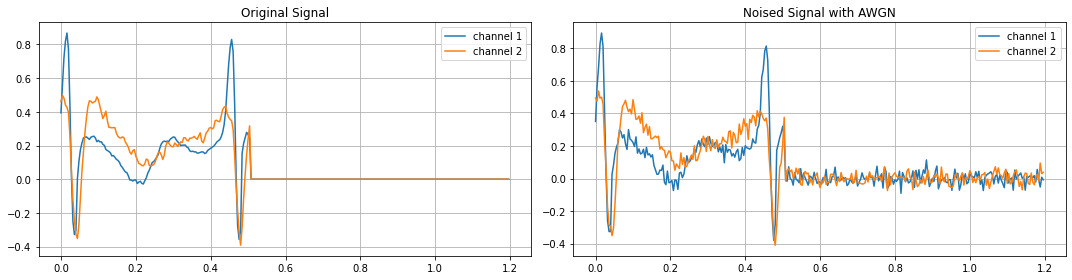

In [93]:
signal = np.reshape(X_train_600[0], (2, 300))
noised_signal = np.reshape(X_train_noised_600[0], (2, 300))

plot_noised_signal(signal, noised_signal)

___
# Denoising Signal

- Ditahap ini kita akan coba lakukan Denoising signal menggunakan Deep Learning
    - CNN (Convolutional Neural Network)
    - LSTM (Long-Short Term Memory)
    - DAE (Denoising Auto Encoder)
- Sumber : [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html) <br>
![](resource/DAE.png)

#### Visualization util

In [94]:
def plot_model_history(history):
    
    fig, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss (RMSE)')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()
    

In [95]:
def plot_decoded_signal(decoded_signal, original_signal, name):
    time = np.arange(len(decoded_signal[0])) / fs
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.plot(decoded_signal[0])
    plt.plot(decoded_signal[1])
    plt.title("Denoised Signal - " + name)
    plt.legend(['channel 1', 'channel 2'])
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(original_signal[0])
    plt.plot(original_signal[1])
    plt.title("Original Signal")
    plt.legend(['channel 1', 'channel 2'])
    plt.grid()

    plt.tight_layout()
    plt.show()

### Transform data

In [107]:
# reshape sequence from (s, 600) to (s, 2, 300)
X_train = []
for data in X_train_600:
    data = np.reshape(data, (2, 300))
    X_train.append(data)
    
X_test = []
for data in X_test_600:
    data = np.reshape(data, (2, 300))
    X_test.append(data)


# reshape sequence from (s, 600) to (s, 2, 300)
X_train_noised = []
for data in X_train_noised_600:
    data = np.reshape(data, (2, 300))
    X_train_noised.append(data)
    

X_test_noised = []
for data in X_test_noised_600:
    data = np.reshape(data, (2, 300))
    X_test_noised.append(data)

# convert to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

X_train_noised = np.array(X_train_noised)
X_test_noised = np.array(X_test_noised)


# reshape sequence from (s, 2, 300) to (s*2, 300) 

s, v, p = X_train.shape
X_train = np.reshape(X_train, (s*v, p))

s, v, p = X_test.shape
X_test = np.reshape(X_test, (s*v, p))

s, v, p = X_train_noised.shape
X_train_noised = np.reshape(X_train_noised, (s*v, p))

s, v, p = X_test_noised.shape
X_test_noised = np.reshape(X_test_noised, (s*v, p))

In [109]:
X_train_600.shape, X_test_600.shape, X_train_noised_600.shape, X_test_noised_600.shape

((33060, 600), (12906, 600), (33060, 600), (12906, 600))

In [110]:
X_train.shape, X_test.shape, X_train_noised.shape, X_test_noised.shape

((66120, 300), (25812, 300), (66120, 300), (25812, 300))

#### Custom loss 

In [28]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

### Denoising Deep Autoencoder

In [29]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


Using TensorFlow backend.


In [115]:
def DeepAutoEncoder(input_dim):
    autoencoder = Sequential(name="deep_autoencoder")
    autoencoder.add(InputLayer(input_shape=(input_dim,))) 
    autoencoder.add(Dense(256, activation='tanh', name="encode_1"))
    autoencoder.add(Dense(128, activation='tanh', name="encode_2"))
    autoencoder.add(Dense(64, activation='tanh', name="encode_3"))
    autoencoder.add(Dense(32, activation='tanh', name="encode_4"))
    autoencoder.add(Dense(16, activation='tanh', name="encode_5"))
    
    autoencoder.add(Dense(32, activation='tanh', name="decode_1"))
    autoencoder.add(Dense(64, activation='tanh', name="decode_2"))
    autoencoder.add(Dense(128, activation='tanh', name="decode_3"))
    autoencoder.add(Dense(256, activation='tanh', name="decode_4"))
    autoencoder.add(Dense(input_dim, activation='tanh', name="decode_5"))
    autoencoder.summary()
    
    autoencoder.compile(
                        optimizer = 'adam', 
                        loss = rmse)
    return autoencoder

In [116]:
model_name_deep_AE = 'best_denoising_deep_AE.h5'
input_dim = X_train_noised.shape[1]
deep_autoencoder = DeepAutoEncoder(input_dim)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),
             ModelCheckpoint(
                         filepath = model_name_deep_AE, 
                         monitor = 'val_loss',
                         save_best_only = True)]

history = deep_autoencoder.fit(X_train_noised, X_train,
                        epochs = 50,
                        batch_size = 64,
                        callbacks = callbacks,
                        shuffle = True,
                        validation_data = (X_test_noised, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (Dense)             (None, 256)               77056     
_________________________________________________________________
encode_2 (Dense)             (None, 128)               32896     
_________________________________________________________________
encode_3 (Dense)             (None, 64)                8256      
_________________________________________________________________
encode_4 (Dense)             (None, 32)                2080      
_________________________________________________________________
encode_5 (Dense)             (None, 16)                528       
_________________________________________________________________
decode_1 (Dense)             (None, 32)                544       
_________________________________________________________________
decode_2 (Dense)             (None, 64)                2112      
__________

- save model

In [75]:
deep_autoencoder.save(model_name_deep_AE)

- plot training history

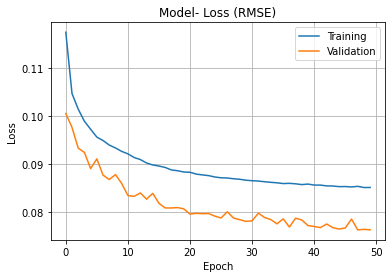

In [76]:
plot_model_history(history)

- save training history

In [77]:
history_df = pd.DataFrame(history.history)

history_df.to_csv("history_Training_Denoising_Deep_AE.csv", index=False)

- Apply model to train dataset

In [78]:
X_train_denoised = deep_autoencoder.predict(X_train_noised)

- Apply model to test dataset

In [79]:
X_test_denoised = deep_autoencoder.predict(X_test_noised)

- save denoising result

In [80]:
s, p = X_train_denoised.shape
X_train_denoised = np.reshape(X_train_denoised, (int(s/2), 2, p))

In [81]:
s, p = X_test_denoised.shape
X_test_denoised = np.reshape(X_test_denoised, (int(s/2), 2, p))

In [82]:
s, v, p = X_train_denoised.shape
X_train_denoised = np.reshape(X_train_denoised, (s, v*p))

In [83]:
s, v, p = X_test_denoised.shape
X_test_denoised = np.reshape(X_test_denoised, (s, v*p))

In [84]:
train_denoised_df = pd.DataFrame(np.hstack((X_train_denoised, np.expand_dims(y_train, 1))))
train_denoised_df.to_csv(dataset_folder + "train_all_Deep_AE.csv", index=None, header=None)

test_denoised_df = pd.DataFrame(np.hstack((X_test_denoised, np.expand_dims(y_test, 1))))
test_denoised_df.to_csv(dataset_folder + "test_all_Deep_AE.csv", index=None, header=None)


- plot denoising result

In [85]:
X_train[0].shape

(300,)

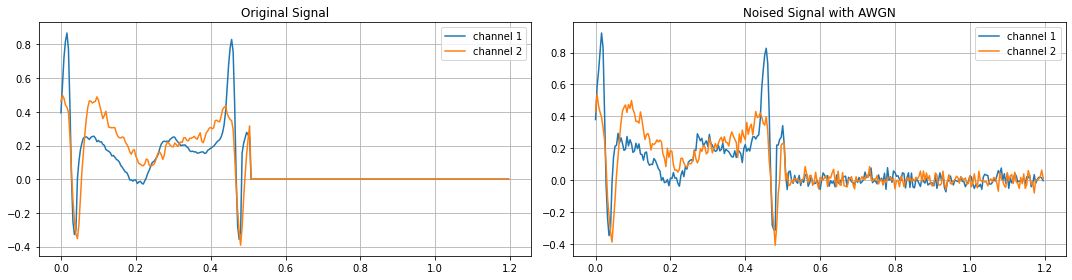

In [86]:
signal = np.reshape(np.array([X_train[0], X_train[1]]), (2, 300))
noised_signal = np.reshape(np.array([X_train_noised[0], X_train_noised[1]]), (2, 300))

plot_noised_signal(signal, noised_signal)

In [87]:
X_train_denoised.shape

(33060, 600)

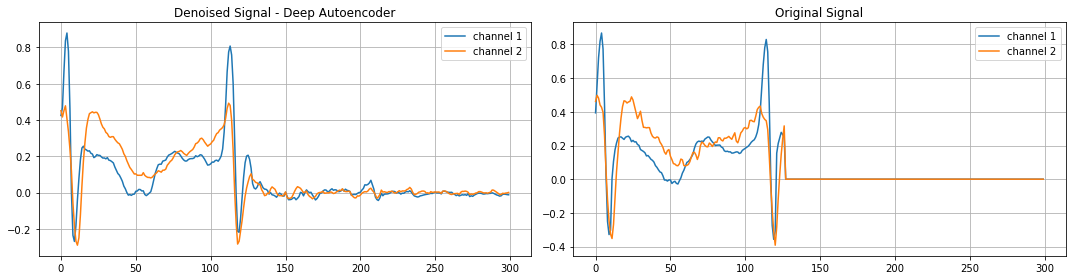

In [88]:
signal = np.reshape(np.array([X_train[0], X_train[1]]), (2, 300))
denoised_signal = np.reshape(X_train_denoised[0], (2, 300))

plot_decoded_signal(denoised_signal, signal,"Deep Autoencoder")

___
### Denoising CNN - Autoencoder

In [37]:
from keras.layers import Conv1D, MaxPooling1D as MaxP1D, UpSampling1D as UpSm1D

In [56]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train_noised = X_train_noised.reshape(len(X_train_noised), X_train_noised.shape[1], 1)
X_test_noised = X_test_noised.reshape(len(X_test_noised), X_test_noised.shape[1], 1)

X_train = X_train[:,:184,:]
X_test = X_test[:,:184,:]
X_train_noised = X_train_noised[:,:184,:]
X_test_noised = X_test_noised[:,:184,:]

In [38]:
def ConvAutoEncoder(input_dim):
    conv_net = Sequential(name="conv_autoencoder")
    conv_net.add(InputLayer(input_shape=(input_dim,1))) 
    
    conv_net.add(Conv1D(128, 3, activation='relu', padding='same', name="encode_1"))
    conv_net.add(MaxP1D(2, padding='same', name="encode_2"))
    conv_net.add(Conv1D(64, 3, activation='relu', padding='same', name="encode_3"))
    conv_net.add(MaxP1D(2, padding='same', name="encode_4"))
#     conv_net.add(Conv1D(32, 3, activation='relu', padding='same', name="encode_5"))
#     conv_net.add(MaxP1D(2, padding='same', name="encode_6"))
    
#     conv_net.add(Conv1D(32, 3, activation='relu', padding='same', name="decode_1"))
#     conv_net.add(UpSm1D(2, name="decode_2"))
    conv_net.add(Conv1D(64, 3, activation='relu', padding='same', name="decode_3"))
    conv_net.add(UpSm1D(2, name="decode_4"))
    conv_net.add(Conv1D(128, 3, activation='relu', padding='same', name="decode_5"))
    conv_net.add(UpSm1D(2, name="decode_6"))
    conv_net.add(Conv1D(1, 3, activation='sigmoid', padding='same', name="decode_7"))

    conv_net.summary()
    
    conv_net.compile(
                    optimizer = 'adam', 
                    loss = rmse)
    
    return conv_net

In [39]:
model_name_conv_AE = 'best_denoising_conv_AE.h5'

input_dim = X_train_noised.shape[1]
conv_autoencoder = ConvAutoEncoder(input_dim)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(
                         filepath = model_name_conv_AE, 
                         monitor = 'val_loss', 
                         save_best_only = True)]

history = conv_autoencoder.fit(X_train_noised, X_train,
                                epochs = 50,
                                batch_size = 64,
                                shuffle = True,
                                callbacks = callbacks,
                                validation_data = (X_test_noised, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (Conv1D)            (None, 184, 128)          512       
_________________________________________________________________
encode_2 (MaxPooling1D)      (None, 92, 128)           0         
_________________________________________________________________
encode_3 (Conv1D)            (None, 92, 64)            24640     
_________________________________________________________________
encode_4 (MaxPooling1D)      (None, 46, 64)            0         
_________________________________________________________________
decode_3 (Conv1D)            (None, 46, 64)            12352     
_________________________________________________________________
decode_4 (UpSampling1D)      (None, 92, 64)            0         
_________________________________________________________________
decode_5 (Conv1D)            (None, 92, 128)           24704     
__________

In [98]:
conv_autoencoder.save(model_name_conv_AE)

NameError: name 'conv_autoencoder' is not defined

In [ ]:
plot_model_history(history)

In [41]:
decoded_ecgs = conv_autoencoder.predict(X_test_noised)

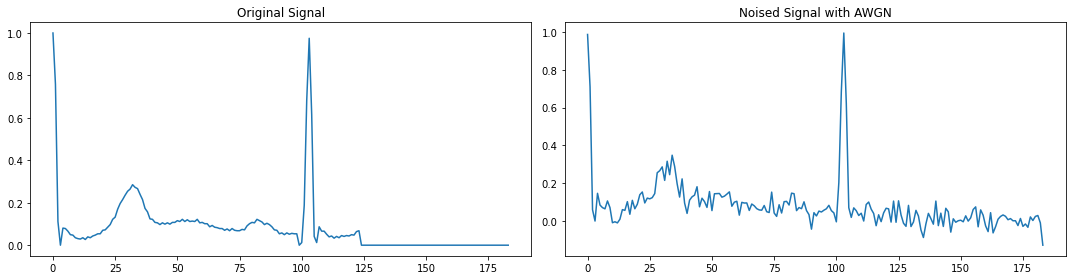

In [42]:
plot_noised_signal(X_test[0], X_test_noised[0])

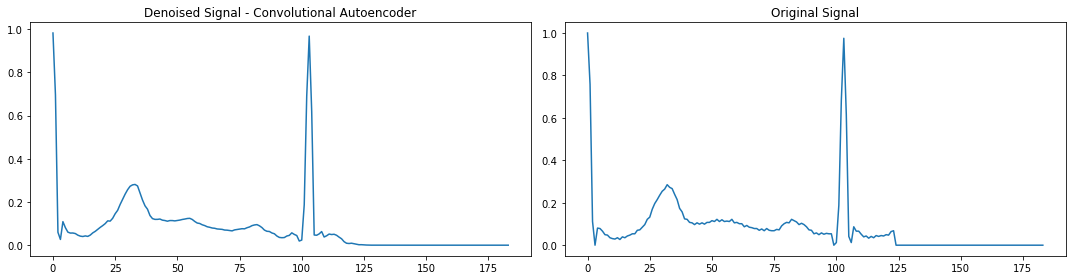

In [43]:
plot_decoded_signal(decoded_ecgs[0], X_test[0],"Convolutional Autoencoder")

### Denoising LSTM - Autoencoder (Sequence to Sequence)

In [17]:
from keras.layers import LSTM, RepeatVector, CuDNNLSTM, TimeDistributed


In [18]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train_noised = X_train_noised.reshape(len(X_train_noised), X_train_noised.shape[1], 1)
X_test_noised = X_test_noised.reshape(len(X_test_noised), X_test_noised.shape[1], 1)

X_train = X_train[:,:184,:]
X_test = X_test[:,:184,:]
X_train_noised = X_train_noised[:,:184,:]
X_test_noised = X_test_noised[:,:184,:]

In [20]:
def LSTM_AutoEncoder(input_dim):
    lstm = Sequential(name="lstm_autoencoder")
    lstm.add(InputLayer(input_shape=(input_dim,1))) 
    
    lstm.add(CuDNNLSTM(100, name="encode_1"))

    lstm.add(RepeatVector(input_dim, name="decode_1"))
    lstm.add(CuDNNLSTM(100, return_sequences=True, name="decode_2"))
    lstm.add(TimeDistributed(Dense(1, activation="sigmoid")))
    
    lstm.summary()
    
    lstm.compile(
                optimizer = 'adam', 
                loss = rmse)
    
    return lstm

In [21]:
model_name_LSTM_AE = 'best_denoising_LSTM_AE.h5'

input_dim = X_train_noised.shape[1]
lstm_autoencoder = LSTM_AutoEncoder(input_dim)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(
                         filepath = model_name_LSTM_AE, 
                         monitor = 'val_loss', 
                         save_best_only = True)]

history = lstm_autoencoder.fit(X_train_noised, X_train,
                                epochs = 50,
                                batch_size = 64,
                                callbacks = callbacks,
                                shuffle = True,
                                validation_data = (X_test_noised, X_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_1 (CuDNNLSTM)         (None, 100)               41200     
_________________________________________________________________
decode_1 (RepeatVector)      (None, 184, 100)          0         
_________________________________________________________________
decode_2 (CuDNNLSTM)         (None, 184, 100)          80800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 184, 1)            101       
Total params: 122,101
Trainable params: 122,101
Non-trainable params: 0
_________________________________________________________________
Train on 100000 samples, validate on 21892 samples
Epoch 1/50
100000/100000 [==============================] - 237s 2ms/step - loss: 0.1553 - val_loss: 0.1151
Epoch 2/50
100000/100000 [==============================] - 230s 2ms/step - loss: 0.1078 - val_loss: 0.1028
E

In [22]:
lstm_autoencoder.save(model_name_LSTM_AE)

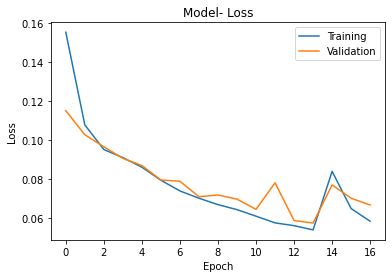

In [23]:
plot_model_history(history)

In [24]:
decoded_ecgs = lstm_autoencoder.predict(X_test_noised)

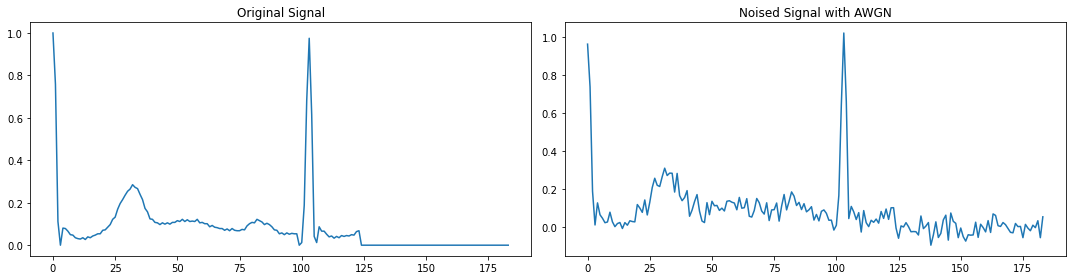

In [25]:
plot_noised_signal(X_test[0], X_test_noised[0])

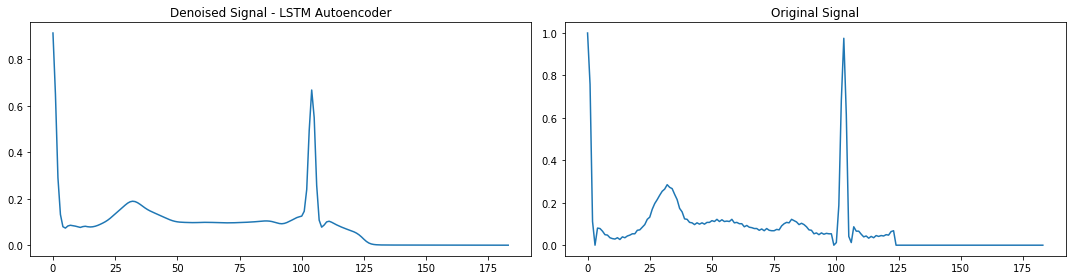

In [26]:
plot_decoded_signal(decoded_ecgs[0], X_test[0],"LSTM Autoencoder")